In [65]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image

# Temperature Sensor Configurations

Explanation of below functions:  
***Continuous conversion mode:*** The device continuously performs temperature conversions in this mode, as shown in Figure 7-3, and updates the temperature result register at the end of every active conversion  
***One-shot mode:*** After the device completes a (temperature conversion) one-shot conversion, the device goes to the *low-power shutdown mode*.  

In [56]:
class TMP117():
    def __init__(self, mode, time_step, duration, CC_params, OS_params):
        self.mode = mode
        self.time_step = time_step
        self.duration = duration
        self.CC_params = CC_params
        self.OS_params = OS_params

    def calculate_power(self, time):
        if self.mode == "CC": 
            standByCurrentConsumption = 1.25
            activeCurrentConsumption = 135
            convCycleTime = self.CC_params[0]
            num_averages = self.CC_params[1]

            activeConversionTime = num_averages*0.0155
            standbyTime =  convCycleTime- activeConversionTime
            amps = ((activeCurrentConsumption*activeConversionTime) + (standByCurrentConsumption*standbyTime)) / convCycleTime

            power = (amps * 3.3) / 1000

        elif self.mode == "OS":
            return 0 # add more stuff ........

        return power 

    def returnArr(self, time, active_times, standby):
        time = time.tolist()
        length = len(time)
        standby = 1.25 / 1000 # default power when active conversion is off
        arr = [standby] * len(time) # creating corresponding power array to time intervals, default values 

        # check if the given start and end time is a valid value in the time array and round to nearest value 
        for times in active_times:
            start = times[0]
            end = times[1]
            if times[0] not in time:
                print("start or end time is invalid, rounding to nearest whole number")
                start = round(start)

            if times[1] not in time:
                print("start or end time is invalid, rounding to nearest whole number")
                end = round(end)

            start_index = time.index(start) 
            end_index = time.index(end) 

            # calculate power here for active conversion period
            # if statement for power vs data
            
            power = self.calculate_power(time)
            for i in range(start_index, end_index+1):
                arr[i] = power   
            
        return arr

    def getData(self, time):
        '''
        The data in the result register is in two's complement format, 
        has a data width of 16 bits and a resolution of 7.8125 m°C.
        
        Changing the conversion cycle period also affects the temperature result update rate because the temperature 
        result register is updated at the end of every active conversion.
        
        Storing 16-bit value at the end of each conversion cycle (1s)
        '''
        for t in time:
            
        
        return 0

    def Simulation(self, active_times):
        time = np.arange(0,self.duration,self.time_step) #time at which to collect data
        #active_times = [[4,5], [5,6]]

        power = self.getPower(time, active_times)
        data = self.getData(time)

        return time, power, data
    


### Parameters for TMP117 (to be changed by teams)  
...add more explanation of what each input does later  
add explanation of what possible inputs including default are for each input ...  

**Continuous conversion (if selected) params**:  
**possible conversion cycle times (see column 1 of table below)**: 0.0155, 0.125, 0.25, 0.5, 1, 4, 8, 16  
**possible averaging inputs**: 0, 8, 32, 64


In [59]:
#Image("convTimes.png")

#### TO-DO (teams set inputs)

In [73]:
mode = 'CC'
time_step = 1 # possible inputs: ...
duration = 20 # possible inputs: ...
convCycle = 0.0155 # possible inputs: .0155, 0.125, 0.25, 0.5, 1, 4, 8, 16, see above table (column 1)
num_averages = 0 # possible inputs: 0, 8, 32, 64
CC_params = [convCycle, num_averages] # set to 0 if mode chosen is not CC
OS_params = [num_averages] # set to 0 if mode chosen is not OS

In [77]:
x = TMP117(mode, time_step, duration, CC_params, OS_params) # creating TMP117 class
active_times = [[1,2], [7,9], [12,15]]
time, power, data = x.Simulation(active_times) # getting power, data, time 

In [78]:
print(power)

[0.00125, 0.004125, 0.004125, 0.00125, 0.00125, 0.00125, 0.00125, 0.004125, 0.004125, 0.004125, 0.00125, 0.00125, 0.004125, 0.004125, 0.004125, 0.004125, 0.00125, 0.00125, 0.00125, 0.00125]


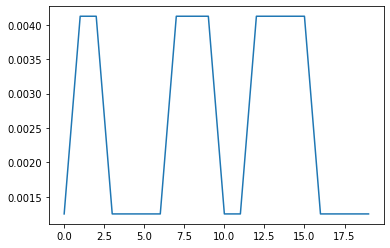

In [79]:
plt.plot(time, power);

# Accelerometer

# Magnetometer

# Thermopile